# Processing Our Data - 1

## Welcome to EchoScope's Data Processing Notebook!

This notebook serves as the training data preparation pipeline for EchoScope, a deep learning–powered radio signal modulation classifier. While the end goal of EchoScope is to accept raw RF .wav files from users via a web interface and predict their modulation type, this notebook focuses specifically on preprocessing and augmenting training data to ensure the underlying model is robust, generalizable, and performant.

### What This Notebook Does
Currently, we are working with the RadioML (RML) 2016.10A dataset, which contains labeled in-phase/quadrature (I/Q) radio signal samples across various modulation schemes and signal-to-noise ratios (SNRs).

You can find it here: https://www.kaggle.com/datasets/nolasthitnotomorrow/radioml2016-deepsigcom/data

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from tqdm import tqdm
from itertools import islice
import random
from scipy import stats

In [3]:
radio_ml_2016 = pd.read_pickle('../data/radio_ml_2016/RML2016.10a_dict.pkl')

Sadly, working with the RadioML 2016.10A dataset isn't as straightforward as loading clean, column data into a pandas dataframe.

Instead, RML is structured as a dictionary of key-value pairs, where each key is a tuple of the form (modulation_type, SNR), and the corresponding value is a NumPy array of shape (n_samples, 2, 128), representing I/Q samples.

As a result, pandas won’t be our best friend here😭, unlike other projects (like NutriMap, another amazing ML project you can check out on my GitHub🙏) where structured tabular data made DataFrame operations ideal.

For EchoScope, NumPy will take the lead, offering the flexibility and performance we need to manipulate, normalize, and augment raw I/Q data efficiently.

In [4]:
radio_ml_2016[('QPSK', 10)].shape

(1000, 2, 128)

In [5]:
mods_snrs = list(radio_ml_2016.keys())
key = mods_snrs[0]
samples = radio_ml_2016[key]
print(key, samples.shape)

('QPSK', 2) (1000, 2, 128)


The output of our above code signifies that RML's training data has 1000 examples for each modulation type. 

In alignment with our above cell annotation, each example has subsequent dimensions of 2, 128.

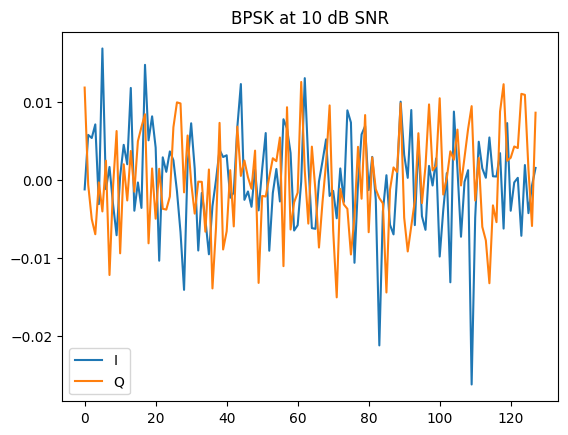

In [6]:
iq_sample = radio_ml_2016[('BPSK', 10)][0]
i = iq_sample[0]
q = iq_sample[1]

plt.plot(i, label='I')
plt.plot(q, label='Q')
plt.legend()
plt.title("BPSK at 10 dB SNR")
plt.show()


### What is this graph?
This graph shows the IQ of an example. 

The I/Q (In-phase and Quadrature, not intelligence quotient) components represent the real and imaginary parts of a complex baseband signal.

Together, they capture both amplitude and phase information of a radio waveform over time. Plotting them helps visualize modulation patterns and assess signal characteristics (but we won't be spamming plots in this notebook, statistical data will work just fine for analysis).


In [7]:
def add_gaussian_noise(iq_samples, noise_std=0.01):
    noise = noise_std * np.random.randn(*iq_samples.shape)
    return iq_samples + noise

In [8]:
def random_phase_shift(iq_samples, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(iq_samples, shift, axis=-1)

In [9]:
def random_amplitude_scaling(iq_samples, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(*scale_range)
    return iq_samples * scale

In [10]:
def augment_iq_sample(iq_sample):
    augmented_res = add_gaussian_noise(iq_sample, noise_std=0.02)
    augmented_res = random_phase_shift(augmented_res, max_shift=3)
    augmented_res = random_amplitude_scaling(augmented_res)
    return augmented_res

### What the heck are these features?

#### Gaussian Distribution (Noise)
In machine learning, especially when working with images or image-like tensors (such as spectrograms in EchoScope), Gaussian noise is often used to model or simulate real-world noise. This type of noise helps make models more robust by mimicking natural variations in the data. Since spectrograms can contain background fluctuations or interference, applying or modeling Gaussian noise can improve interpretation and generalization.

Gaussian noise also forms a psuedo bell curve within the noise distribution of our tensor, helpful for ML interpretation. 

#### Random Phase Shift/Amplitude Scaling
We use random phase shifts/random amplitude scaling to make the model better at generalizing.

In the real world, radio signals often arrive with small timing or phase differences (due to hardware, movement, or the environment). If we only train on perfectly aligned signals, the model might fail on slightly shifted ones.

##### Our augment_iq_sample runs the initial iq sample through all of these methods, outputting a more varied and diverse sample.

In [10]:
for key in tqdm(mods_snrs, desc="Normalizing & Scaling raw IQ data"):
    samples = radio_ml_2016[key]
    num_samples = samples.shape[0]

    for i in range(num_samples):
        for ch in range(samples.shape[1]):
            channel_data = samples[i, ch, :]
            mean = channel_data.mean()
            std = channel_data.std()
            samples[i, ch, :] = (channel_data - mean) / (std + 1e-10)
    
    data_reshaped = samples.transpose(0, 2, 1).reshape(-1, 2)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_reshaped)
    scaled_data = scaled_data.reshape(num_samples, 128, 2).transpose(0, 2, 1)
    radio_ml_2016[key] = scaled_data

    augmented_samples = np.empty_like(scaled_data)
    for i in range(num_samples):
        augmented_samples[i] = augment_iq_sample(scaled_data[i])
    radio_ml_2016[key] = augmented_samples

Normalizing & Scaling raw IQ data: 100%|█████| 220/220 [00:09<00:00, 22.59it/s]


### What does this preprocessing loop do?
This preprocessing loop performs normalization, scaling, and data augmentation for each modulation-SNR key in the dataset. 

#### Step 1: Normalize each individual I/Q channel sample to zero mean and unit variance.
This ensures that each sample is on a comparable scale and helps stabilize training, especially for models sensitive to input distribution (e.g., deep learning models).

#### Step 2: Apply sklearn's StandardScaler to the full dataset (flattened per sample).
This step removes global mean and scales variance across all samples. This helps further normalize differences across samples and aligns the dataset with model expectations.

#### Step 3: Reshape the scaled data back to the original format and apply data augmentation.
The augment_iq_sample function simulates real-world distortions (e.g., phase noise, jitter, detailed in our above cell annotation), improving the model’s generalization ability and robustness to variations.

##### The final result is a uniformly scaled, normalized, and augmented dataset suitable for training high-performance models on raw radio I/Q data.

In [11]:
def generate_spectrogram(iq_sample, fs=1.0, nperseg=32, noverlap=24, 
                          noise_std=0.01, shift_max=2,
                         pad_to=256):
    iq_sample = iq_sample / (np.linalg.norm(iq_sample, axis=1, keepdims=True) + 1e-10)
    
    if pad_to > iq_sample.shape[1]:
        pad_width = pad_to - iq_sample.shape[1]
        iq_sample = np.pad(iq_sample, ((0, 0), (0, pad_width)), mode='reflect')

    spec_channels = []
    for ch in range(iq_sample.shape[0]):
        f, t, Sxx = spectrogram(iq_sample[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        Sxx = np.abs(Sxx)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        spec_channels.append(Sxx_db)

    spectrogram_img = np.stack(spec_channels, axis=0)
    
    return spectrogram_img

In [12]:
def generate_multi_resolution_spectrogram(iq_sample, fs=1.0, configs=[(32, 24), (64, 48), (128, 96)], pad_to=256):
    iq_sample = iq_sample / (np.linalg.norm(iq_sample, axis=1, keepdims=True) + 1e-10)
    if pad_to > iq_sample.shape[1]:
        pad_width = pad_to - iq_sample.shape[1]
        iq_sample = np.pad(iq_sample, ((0, 0), (0, pad_width)), mode='reflect')
    
    all_res_specs = []
    for nperseg, noverlap in configs:
        spec_channels = []
        for ch in range(iq_sample.shape[0]):
            f, t, Sxx = spectrogram(iq_sample[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            Sxx = np.abs(Sxx)
            Sxx_db = 10 * np.log10(Sxx + 1e-10)
            spec_channels.append(Sxx_db)
        spec = np.stack(spec_channels, axis=0) 
        all_res_specs.append(spec)

    stacked = np.concatenate(all_res_specs, axis=0)
    return stacked

In [13]:
spectrograms_dict = {}

for key in tqdm(mods_snrs, desc="Generating spectrograms"):
    samples = radio_ml_2016[key]
    spectrograms = []
    for i in range(samples.shape[0]):
        spec_img = generate_spectrogram(samples[i], )
        spectrograms.append(spec_img)
    spectrograms = np.array(spectrograms)
    spectrograms_dict[key] = spectrograms 

Generating spectrograms: 100%|███████████████| 220/220 [00:44<00:00,  4.94it/s]


In [16]:
all_specs = []
for key in spectrograms_dict:
    all_specs.extend(spectrograms_dict[key].copy())

all_specs = np.stack(all_specs) 
global_mean = all_specs.mean()
global_std = all_specs.std()

for key in spectrograms_dict:
    spectrograms_dict[key] = (spectrograms_dict[key] - global_mean) / (global_std + 1e-9)

np.save("global_mean.npy", global_mean)
np.save("global_std.npy", global_std)

print("Post-standardization stats:")
print("Mean (should be ~0):", all_specs.mean())
print("Std (should be ~1):", all_specs.std())

Post-standardization stats:
Mean (should be ~0): -2.2544584e-06
Std (should be ~1): 1.0000002


### What does this code do?

This function takes our IQ signal list and computes a spectrogram for each channel.

A spectrogram shows how the signal’s frequency content changes over time. For each channel, it calculates the spectrogram, converts the power values to a decibel scale for easier interpretation, and then collects all these spectrograms together into one 3D array. The result is an array where each channel has its own frequency-vs-time spectrogram image, useful for analyzing the signal’s characteristics across different channels.

In [17]:
def print_spectrogram_stats(spectrograms_dict, num_keys=20):
    for key, specs in islice(spectrograms_dict.items(), num_keys):
        num_samples = specs.shape[0]
        sample_shape = specs.shape[1:]
        min_val = specs.min()
        max_val = specs.max()
        mean_val = specs.mean()
        nan_count = np.isnan(specs).sum()
        inf_count = np.isinf(specs).sum()
        total_vals = specs.size

        print(f"Key: {key}")
        print(f" Number of samples: {num_samples}")
        print(f" Spectrogram shape per sample: {sample_shape}")
        print(f" Min value: {min_val:.4f}")
        print(f" Max value: {max_val:.4f}")
        print(f" Mean value: {mean_val:.4f}")
        print(f" NaNs present: {nan_count > 0} ({nan_count} / {total_vals}, {100 * nan_count / total_vals:.5f}%)")
        print(f" Infinite values present: {inf_count > 0} ({inf_count} / {total_vals}, {100 * inf_count / total_vals:.5f}%)")
        print("-" * 40)

print_spectrogram_stats(spectrograms_dict, num_keys=20)

Key: ('QPSK', 2)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 29)
 Min value: -5.1243
 Max value: 2.0142
 Mean value: 0.1082
 NaNs present: False (0 / 986000, 0.00000%)
 Infinite values present: False (0 / 986000, 0.00000%)
----------------------------------------
Key: ('PAM4', 8)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 29)
 Min value: -5.1243
 Max value: 2.0522
 Mean value: -0.5346
 NaNs present: False (0 / 986000, 0.00000%)
 Infinite values present: False (0 / 986000, 0.00000%)
----------------------------------------
Key: ('AM-DSB', -4)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 29)
 Min value: -5.1240
 Max value: 1.6885
 Mean value: 0.4373
 NaNs present: False (0 / 986000, 0.00000%)
 Infinite values present: False (0 / 986000, 0.00000%)
----------------------------------------
Key: ('GFSK', 6)
 Number of samples: 1000
 Spectrogram shape per sample: (2, 17, 29)
 Min value: -5.1243
 Max value: 1.9841
 Mean value: -0.4103

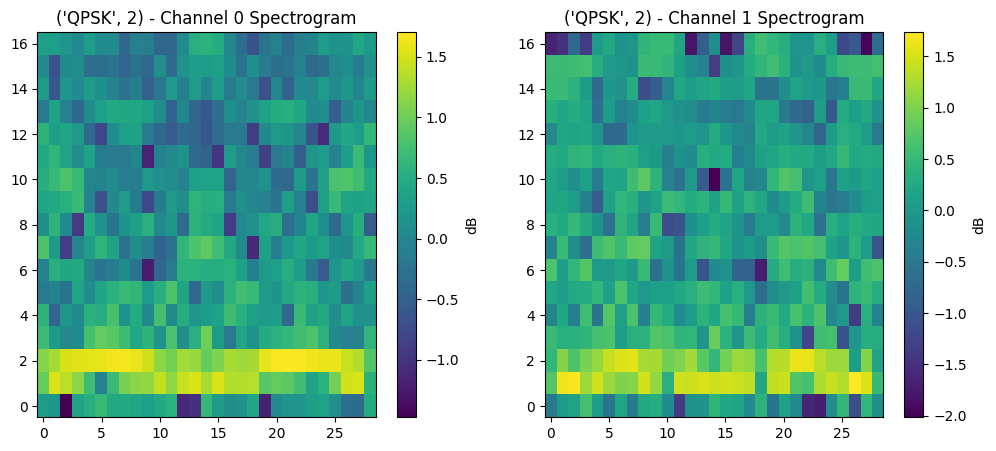

In [18]:
key = list(spectrograms_dict.keys())[0]
sample_idx = 0
spec = spectrograms_dict[key][sample_idx]
plt.figure(figsize=(12, 5))
for ch in range(spec.shape[0]):
    plt.subplot(1, 2, ch+1)
    plt.title(f"{key} - Channel {ch} Spectrogram")
    plt.imshow(spec[ch], aspect='auto', origin='lower')
    plt.colorbar(label='dB')
plt.show()

### Visualizations of our converted spectrograms

In [19]:
print(list(spectrograms_dict.keys())[:5])

[('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8)]


In [20]:
radio_ml_2016_str_keys = {
    str(key): value for key, value in radio_ml_2016.items()
}

spectrograms_dict_str_keys = {
    str(key): value for key, value in spectrograms_dict.items()
}

Here, we convert our processed RML 2016 & spectrograms dictionary into strings to be able to be stored. 

In [21]:
np.savez_compressed("../data/processed_iq_data.npz", **radio_ml_2016_str_keys)

In [22]:
np.savez_compressed("../data/spectrograms.npz", **spectrograms_dict_str_keys)

### A disclaimer about dataset storage

Given that GitHub isn't equivalent to something like Google Drive in terms of data storage, I will not be pushing our data, processed or raw, online. 

If you want to run the next notebook (the actual manifestation of EchoScope's model), I recommend you fully run this notebook after downloading the RML 2016 data, which in turn will save our .npz files onto your local computer.

The .npz files will not be provided online, and to obtain them, running this notebook is required. 